In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import Latex
import scipy.stats as stats
import sympy as sy
import pywt


In [187]:
def data_generate(N,mu,sigma):
    data=np.zeros((N,2),dtype=float)
    data[:,0]=stats.uniform.rvs(loc=0.0,scale=1.0,size=N)
    data=np.sort(data,axis=0)
    err =stats.norm.rvs(loc=mu,scale=np.square(sigma),size=N)
    data[:,1]=np.sin(4*data[:,0])+err
    return data
class KernelSmoother:
    def __init__(self,X=None,y=None):
        self.X=X
        self.y=y
    
    def epan(self,x):
        if(-1<=x and x<=1):
            return 0.75*(1-x*x)
        else:
            return 0.0
    def tricube(self,x):
        if(-1<=x and x<=1):
            return np.power((1-np.power(abs(x),3)),3)
        else:
            return 0.0
    
    def knn(self,x,K=30):
        N =self.X.shape[0]
        dist_sq =np.zeros((N,),dtype=float)
        for i in range(N):
            dist_sq[i]=abs(self.X[i]-x)
        nearest_partition =np.argpartition(dist_sq,K,axis=0)
        return np.mean(self.y[nearest_partition[:K]])
    
    def fit(self,data,X_p,kind="knn",lbd=0.2):
        N=data.shape[0]
        X=data[:,0]
        y=data[:,1]
        
        self.X=X
        self.y=y
        
        
        y_p =np.zeros((X_p.shape[0],),dtype=float)
        if(kind=="knn"):
            y_p =np.array([self.knn(xx) for xx in X_p],dtype=float)
        elif(kind=="epan"):
            for i in range(y_p.shape[0]):
                weights =np.zeros((N,),dtype=float)
                
                for j in range(weights.shape[0]):
                    weights[j]=self.epan(abs(X[j]-X_p[i])/lbd)
                #print('weights ',weights)
                y_p[i]=(np.dot(weights,y))/np.sum(weights)
        else:
            for i in range(y_p.shape[0]):
                weights =np.zeros((N,),dtype=float)
                for j in range(weights.shape[0]):
                    weights[j]=self.tricube(abs(X[j]-X_p[i])/lbd)
                y_p[i]=np.dot(weights,y)/np.sum(weights)
        
        return y_p
        
        
        
        
    
        
    
        

In [188]:
data =data_generate(N=100,mu=0.0,sigma=1.0/3.0)
lines =np.linspace(0,1,1000)
ks =KernelSmoother()


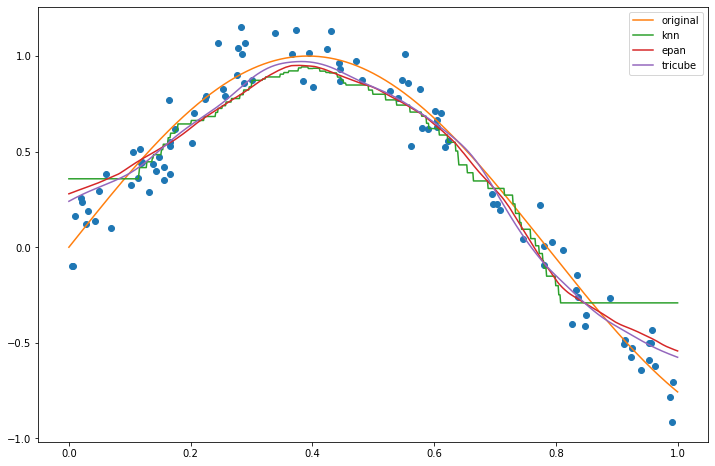

In [189]:
plt.subplots(figsize=(12,8))
plt.plot(data[:,0],data[:,1],'o')
plt.plot(lines,np.sin(4*lines),label='original')
y_p =ks.fit(data=data,X_p=lines,kind="knn")
plt.plot(lines,y_p,label='knn')
y_p =ks.fit(data=data,X_p=lines,kind="epan")
plt.plot(lines,y_p,label='epan')
y_p =ks.fit(data=data,X_p=lines,kind="tricube")
plt.plot(lines,y_p,label='tricube')
plt.legend()

In [190]:
class LocalPolyRegression:
    def __init__(self,p=1):
        self.p =p
    def epan(self,x):
        if(-1<=x and x<=1):
            return 0.75*(1-x*x)
        else:
            return 0.0
    def fit(self,data,X_p,p=1,lbd=0.2):
        N=data.shape[0]
        m =X_p.shape[0]
        X =np.zeros((N,p+1),dtype=float)
        X_p_a =np.zeros((m,p+1),dtype=float)
        X_p_a[:,0]=np.ones((m,),dtype=float)
        X[:,0]=np.ones((N,),dtype=float)
        
        for i in range(p):
            
            X[:,i+1]=np.multiply(X[:,i],data[:,0])
            X_p_a[:,i+1]=np.multiply(X_p_a[:,i],X_p)
        
        weights =np.zeros((N,),dtype=float)
        var =np.zeros((m,),dtype=float)
        y_p =np.zeros((m,),dtype=float)
        equi_kernel =np.zeros((m,N),dtype=float)
        for i in range(m):
            weights =np.array([self.epan(abs(xx-X_p[i])/lbd) for xx in data[:,0]],dtype=float)
            W =np.diag(weights)
            #print('weights ',weights)
            beta =np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T.dot(W))
            equi_kernel[i,:]=X_p_a[i,:][np.newaxis,:].dot(beta)
            var[i] =np.linalg.norm(X_p_a[i,:][np.newaxis,:].dot(beta))
            var[i] =var[i]*var[i]
            beta =beta.dot(data[:,1][:,np.newaxis])
            #print('beta ',beta)
            y_p[i]=X_p_a[i,:][np.newaxis,:].dot(beta)
        
        return [y_p,var,equi_kernel]
            
        

In [191]:
lpr =LocalPolyRegression()
[y2,var2,_]=lpr.fit(data=data,X_p=lines,p=1,lbd=0.2)

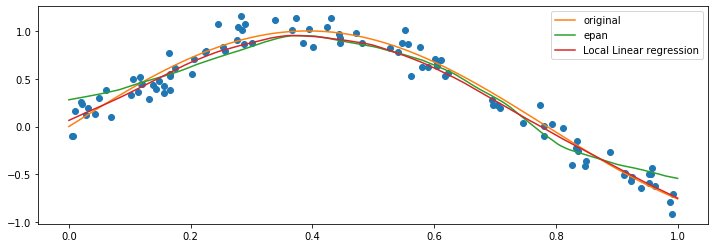

In [192]:
plt.subplots(figsize=(12,4))
plt.plot(data[:,0],data[:,1],'o')
plt.plot(lines,np.sin(4*lines),label='original')
y_p =ks.fit(data=data,X_p=lines,kind="epan")
plt.plot(lines,y_p,label='epan')
plt.plot(lines,y2,label='Local Linear regression')
plt.legend()

In [193]:
lpr3 =LocalPolyRegression()
[y3,var3,euqi3]=lpr3.fit(data=data,X_p=lines,p=2,lbd=0.2)

lpr4 =LocalPolyRegression()
[y4,var4,_]=lpr4.fit(data=data,X_p=lines,p=0,lbd=0.2)

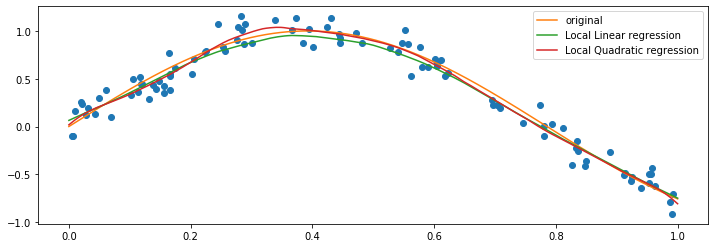

In [194]:
plt.subplots(figsize=(12,4))
plt.plot(data[:,0],data[:,1],'o')
plt.plot(lines,np.sin(4*lines),label='original')
plt.plot(lines,y2,label='Local Linear regression')
plt.plot(lines,y3,label='Local Quadratic regression')
plt.legend()

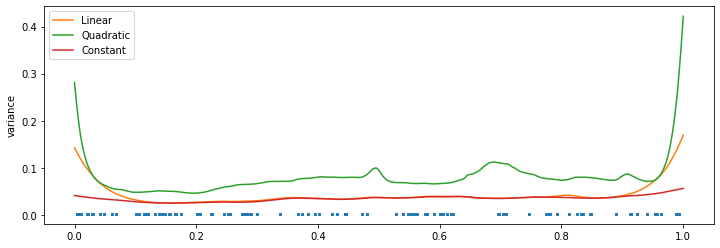

In [195]:
plt.subplots(figsize=(12,4))

plt.ylabel('variance')
plt.plot(data[:,0],0.002*np.ones((data.shape[0],),float),'s',markersize=2)
plt.plot(lines,var2,label='Linear')
plt.plot(lines,var3,label='Quadratic')
plt.plot(lines,var4,label='Constant')
plt.legend()

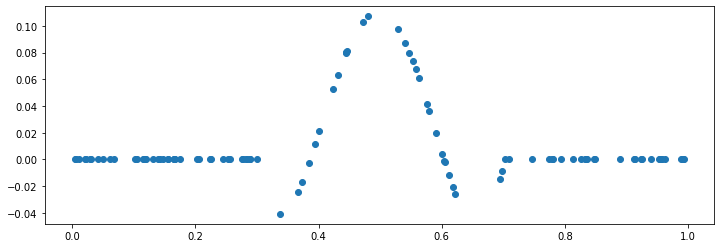

In [203]:
plt.subplots(figsize=(12,4))
plt.plot(data[:,0],euqi3[500,:],'o')

In [3]:
print(df3.shape)

(462, 10)


In [4]:
df3 = pd.read_table("./SAheart.txt",sep=',',index_col=0)
df3['famhist'][df3['famhist']=='Present']=1
df3['famhist'][df3['famhist']=='Absent']=0
data =df3.values

/root/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
X=data[:,[0,6]]
y=data[:,9]
X =np.array(X,dtype=float)
y =np.array(y,dtype=float)

In [145]:
class LocalLogisticRegression:
    def __init__(self,p=None):
        self.p=p
    
    def epan(self,x):
        if(-1<=x and x<=1):
            return 0.75*(1-x*x)
        else:
            return 0.0
    def irls(self,X,y,K):
        N =X.shape[0]
        p =X.shape[1]
        beta_last =np.ones((p,1),dtype=float)
       # beta =np.array([stats.norm.rvs(loc=0,scale=1,size=p)],dtype=float).reshape(p,1)
        beta =np.zeros((p,1),dtype=float)
        #print('beta ',beta)
        hessian =np.zeros((p,p),dtype=float)
        tol =1e-8
        #print('K ',K)
        while(np.linalg.norm(beta_last-beta)>tol):
            beta_last =beta
            pred =np.zeros((N,1),dtype=float)
            for k in range(N):
                tt =X[k,:][np.newaxis,:].dot(beta)[0][0]
                #print(tt.shape)
                pred[k,0]=(np.exp(tt))/(1+np.exp(tt))
            W =np.diag(np.multiply(pred[:,0],1.0-pred[:,0]))
            #print('pred ',pred)
            #print('W ',W)
            grad =X.T.dot(K).dot(y[:,np.newaxis]-pred)
            hessian =-1.0*X.T.dot(K).dot(W).dot(X)
            beta =beta -0.4*np.linalg.inv(hessian).dot(grad)
        
        return [beta,np.linalg.inv(-1*hessian)]
        
        
    def fit(self,X,y,X_p,p=1,lbd=0.2):
        N=X.shape[0]
        m=X_p.shape[0]
        y_p =np.zeros((m,),dtype=float)
        std =np.zeros((m,2),dtype=float)
        X1 =np.zeros((N,p+1),dtype=float)
        X_p2=np.zeros((m,p+1,),dtype=float)
        K  =np.zeros((N,N),dtype=float)
        W  =np.zeros((N,N),dtype=float)
        beta =np.zeros((p+1,),dtype=float)
        X1[:,0]=np.ones((N,),dtype=float)
        X_p2[:,0]=np.ones((m,),dtype=float)
        for i in range(p):
            X1[:,i+1]=np.multiply(X1[:,i],X)
            X_p2[:,i+1]=np.multiply(X_p2[:,i],X_p)
        for i in range(m):
            weights =np.array([self.epan(abs(X_p[i]-xx)/lbd) for xx in X],dtype=float)
            #print('weights ',weights)
            K =np.diag(weights)
            [beta,hessian_inv]=self.irls(X1,y,K)
            yy =X_p2[i,:][np.newaxis,:].dot(beta)[0][0]
            y_p[i]=(np.exp(yy))/(1+(np.exp(yy)))
            std2=X_p2[i,:][np.newaxis,:].dot(hessian_inv).dot(X_p2[i,:][:,np.newaxis])
            #print('std2 ',std2)
            #print('hessian_inv ',hessian_inv)
            std2=np.sqrt(std2)
            #print('std2 ',std2)
            std[i,0]=((np.exp(yy-2*std2))/(1+np.exp(yy-2*std2)))-y_p[i]
            std[i,1]=((np.exp(yy+2*std2))/(1+np.exp(yy+2*std2)))-y_p[i]
        return [y_p,std]
    
    def kerneldensity(self,X,lines,lbd=0.2):
        N =X.shape[0]
        m =lines.shape[0]
        kernels =np.zeros((N,N),dtype=float)
        density =np.zeros((m,),dtype=float)
        for i in range(m):
            weights =np.array([stats.norm.pdf(xx,loc=lines[i],scale=lbd) for xx in X],dtype=float)
            density[i]=np.mean(weights)
        for i in range(N):
            kernels[i,:]=np.array([stats.norm.pdf(xx,loc=X[i],scale=lbd) for xx in X],dtype=float)
        return [density,kernels]
    def posterior(self,X,y,lines,lbd=0.2):
        N =X.shape[0]
        m =lines.shape[0]
        mask =(y==0)
        X0 =X[mask]
        X1 =X[~mask]
        y0 =y[mask]
        y1 =y[~mask]
        priors =np.zeros((2,),dtype=float)
        priors[0]=y0.shape[0]*1.0/N
        priors[1]=y1.shape[0]*1.0/N
        [density0,_]=self.kerneldensity(X=X0,lines=lines,lbd=lbd)
        [density1,_]=self.kerneldensity(X=X1,lines=lines,lbd=lbd)
        posteriors =np.zeros((m,2),dtype=float)
        for i in range(m):
            posteriors[i,0]=(density0[i]*priors[0])/(density0[i]*priors[0] +density1[i]*priors[1])
            posteriors[i,1]=1.0-posteriors[i,0]
        return posteriors
    
            
        
        

In [146]:
lrr =LocalLogisticRegression()
lbd =30
lines =np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
[yy1,std1]=lrr.fit(X=X[:,0],y=y,X_p=lines,p=1,lbd=lbd)

min  101.0   max  218.0


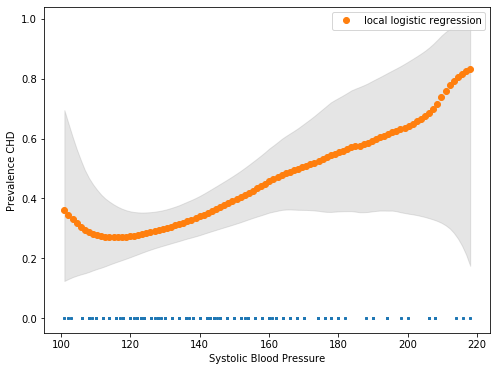

In [143]:
print('min ',np.min(X[:,0]),' ','max ',np.max(X[:,0]))
plt.subplots(figsize=(8,6))
plt.ylabel("Prevalence CHD")
plt.xlabel("Systolic Blood Pressure")
plt.plot(X[:,0],np.zeros((X[:,0].shape[0],),dtype=float),'s',markersize=2)
plt.fill_between(lines,yy1+std1[:,0],yy1+std1[:,1],color='gray',alpha=0.2)
plt.plot(lines,yy1,'o',label='local logistic regression')
plt.legend()

In [138]:
lrr =LocalLogisticRegression()
lbd =10
lines =np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
[yy1,std1]=lrr.fit(X=X[:,1],y=y,X_p=lines,p=1,lbd=lbd)

W  [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.23923589 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2356272  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23533557 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24363208 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23722053 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24701662]]
W  [[0.22272932 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21397636 0.         ... 0.         0.         0.        ]
 [0.         0.         0.21328059 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23374351 0.         0.        ]
 [0.         0.       

W  [[0.18221742 0.         0.         ... 0.         0.         0.        ]
 [0.         0.1625522  0.         ... 0.         0.         0.        ]
 [0.         0.         0.16106128 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20933052 0.         0.        ]
 [0.         0.         0.         ... 0.         0.17095346 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23228382]]
W  [[0.18221726 0.         0.         ... 0.         0.         0.        ]
 [0.         0.162552   0.         ... 0.         0.         0.        ]
 [0.         0.         0.16106107 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20933042 0.         0.        ]
 [0.         0.         0.         ... 0.         0.17095328 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23228378]]
W  [[0.18221716 0.         0.         ... 0.         0.         0.        ]
 [0.         0.16255188 0.    

W  [[0.18876542 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17338071 0.         ... 0.         0.         0.        ]
 [0.         0.         0.17220396 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20988886 0.         0.        ]
 [0.         0.         0.         ... 0.         0.17998022 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22851831]]
W  [[0.18823363 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17273141 0.         ... 0.         0.         0.        ]
 [0.         0.         0.17154635 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20954208 0.         0.        ]
 [0.         0.         0.         ... 0.         0.17937936 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22835082]]
W  [[0.18791309 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17234019 0.    

W  [[0.18743023 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17175106 0.         ... 0.         0.         0.        ]
 [0.         0.         0.17055351 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20901834 0.         0.        ]
 [0.         0.         0.         ... 0.         0.17847186 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22809876]]
W  [[0.18743022 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17175104 0.         ... 0.         0.         0.        ]
 [0.         0.         0.1705535  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20901833 0.         0.        ]
 [0.         0.         0.         ... 0.         0.17847184 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22809876]]
W  [[0.18743021 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17175104 0.    

W  [[0.19258989 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18108948 0.         ... 0.         0.         0.        ]
 [0.         0.         0.1802075  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20850136 0.         0.        ]
 [0.         0.         0.         ... 0.         0.18602704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22319079]]
W  [[0.19258809 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18108735 0.         ... 0.         0.         0.        ]
 [0.         0.         0.18020534 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20850008 0.         0.        ]
 [0.         0.         0.         ... 0.         0.18602505 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22319001]]
W  [[0.19258702 0.         0.         ... 0.         0.         0.        ]
 [0.         0.18108607 0.    

W  [[0.19977174 0.         0.         ... 0.         0.         0.        ]
 [0.         0.19409936 0.         ... 0.         0.         0.        ]
 [0.         0.         0.19366489 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20776288 0.         0.        ]
 [0.         0.         0.         ... 0.         0.19653151 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21557977]]
W  [[0.19967815 0.         0.         ... 0.         0.         0.        ]
 [0.         0.19399517 0.         ... 0.         0.         0.        ]
 [0.         0.         0.19355992 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20768483 0.         0.        ]
 [0.         0.         0.         ... 0.         0.19643182 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21551753]]
W  [[0.19962194 0.         0.         ... 0.         0.         0.        ]
 [0.         0.1939326  0.    

W  [[0.2034764  0.         0.         ... 0.         0.         0.        ]
 [0.         0.20097567 0.         ... 0.         0.         0.        ]
 [0.         0.         0.20078516 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20706059 0.         0.        ]
 [0.         0.         0.         ... 0.         0.20204462 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21067847]]
W  [[0.20338999 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20088444 0.         ... 0.         0.         0.        ]
 [0.         0.         0.20069356 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20698121 0.         0.        ]
 [0.         0.         0.         ... 0.         0.20195544 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21060631]]
W  [[0.2033381  0.         0.         ... 0.         0.         0.        ]
 [0.         0.20082965 0.    

W  [[0.20640543 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20614653 0.         ... 0.         0.         0.        ]
 [0.         0.         0.20612693 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20678248 0.         0.        ]
 [0.         0.         0.         ... 0.         0.20625682 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20717154]]
W  [[0.20618035 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20592003 0.         ... 0.         0.         0.        ]
 [0.         0.         0.20590032 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20655946 0.         0.        ]
 [0.         0.         0.         ... 0.         0.20603092 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20695066]]
W  [[0.20604494 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20578376 0.    

 [0.         0.         0.         ... 0.         0.         0.20344704]]
W  [[0.20796104 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20947864 0.         ... 0.         0.         0.        ]
 [0.         0.         0.20959272 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20571687 0.         0.        ]
 [0.         0.         0.         ... 0.         0.20883455 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20336059]]
W  [[0.20791452 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20943394 0.         ... 0.         0.         0.        ]
 [0.         0.         0.20954816 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2056677  0.         0.        ]
 [0.         0.         0.         ... 0.         0.20878908 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20330868]]
W  [[0.2078866  0.         0.   

W  [[0.21595585 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21859474 0.         ... 0.         0.         0.        ]
 [0.         0.         0.21879125 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21197683 0.         0.        ]
 [0.         0.         0.         ... 0.         0.21748029 0.        ]
 [0.         0.         0.         ... 0.         0.         0.2077149 ]]
W  [[0.21352054 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21636186 0.         ... 0.         0.         0.        ]
 [0.         0.         0.21657355 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20924122 0.         0.        ]
 [0.         0.         0.         ... 0.         0.21516161 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20466493]]
W  [[0.21201018 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21497852 0.    

W  [[0.20967346 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2128407  0.         ... 0.         0.         0.        ]
 [0.         0.         0.21307685 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2049123  0.         0.        ]
 [0.         0.         0.         ... 0.         0.21150223 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19983396]]
W  [[0.20967345 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21284069 0.         ... 0.         0.         0.        ]
 [0.         0.         0.21307684 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20491228 0.         0.        ]
 [0.         0.         0.         ... 0.         0.21150222 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19983394]]
W  [[0.20967344 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21284068 0.    

W  [[0.21219012 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2175925  0.         ... 0.         0.         0.        ]
 [0.         0.         0.21798937 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20384791 0.         0.        ]
 [0.         0.         0.         ... 0.         0.21532672 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19475938]]
W  [[0.21219006 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21759245 0.         ... 0.         0.         0.        ]
 [0.         0.         0.21798933 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20384784 0.         0.        ]
 [0.         0.         0.         ... 0.         0.21532667 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1947593 ]]
W  [[0.21219003 0.         0.         ... 0.         0.         0.        ]
 [0.         0.21759242 0.    

 [0.         0.         0.         ... 0.         0.         0.18782686]]
W  [[0.2152992  0.         0.         ... 0.         0.         0.        ]
 [0.         0.22336481 0.         ... 0.         0.         0.        ]
 [0.         0.         0.22394242 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20232198 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2200251  0.        ]
 [0.         0.         0.         ... 0.         0.         0.18782681]]
W  [[0.21529919 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22336479 0.         ... 0.         0.         0.        ]
 [0.         0.         0.22394241 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20232196 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22002509 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18782678]]
W  [[0.21529918 0.         0.   

W  [[0.21732933 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22708491 0.         ... 0.         0.         0.        ]
 [0.         0.         0.22776777 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20110448 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22309068 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18269953]]
W  [[0.21732925 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22708486 0.         ... 0.         0.         0.        ]
 [0.         0.         0.22776772 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20110436 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22309062 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18269937]]
W  [[0.2173292  0.         0.         ... 0.         0.         0.        ]
 [0.         0.22708483 0.    

W  [[0.21887608 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22989878 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23065343 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19999218 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22543413 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17833052]]
W  [[0.21887604 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22989876 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23065341 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1999921  0.         0.        ]
 [0.         0.         0.         ... 0.         0.2254341  0.        ]
 [0.         0.         0.         ... 0.         0.         0.17833042]]
W  [[0.21887601 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22989874 0.    

W  [[0.22044192 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2327019  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23351821 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19870179 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2278019  0.        ]
 [0.         0.         0.         ... 0.         0.         0.17350184]]
W  [[0.22044181 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23270184 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23351816 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19870158 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22780182 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17350155]]
W  [[0.22044174 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2327018  0.    

W  [[0.2218661  0.         0.         ... 0.         0.         0.        ]
 [0.         0.2352052  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23606569 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19734286 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2299529  0.        ]
 [0.         0.         0.         ... 0.         0.         0.16867366]]
W  [[0.22186579 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23520506 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23606556 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19734226 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22995269 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16867279]]
W  [[0.22186561 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23520497 0.    

W  [[0.22296321 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23711127 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23799676 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19611112 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23161801 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16454021]]
W  [[0.22296303 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2371112  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23799669 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19611075 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2316179  0.        ]
 [0.         0.         0.         ... 0.         0.         0.16453967]]
W  [[0.22296293 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23711115 0.    

W  [[0.22340382 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23791548 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23881009 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19544659 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23231992 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16251434]]
W  [[0.22340353 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23791537 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23880999 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19544598 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23231973 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16251343]]
W  [[0.22340335 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2379153  0.    

W  [[0.22371323 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23850608 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23940691 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1948802  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23283372 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16087971]]
W  [[0.22371243 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23850578 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23940665 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19487848 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23283322 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16087715]]
W  [[0.22371194 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2385056  0.    

W  [[0.22387813 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23886305 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23976823 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19445321 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23313798 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15974282]]
W  [[0.2238768  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23886257 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23976779 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19445034 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23313717 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15973852]]
W  [[0.22387599 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23886228 0.    

W  [[0.22413937 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23936346 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2402724  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19392643 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23357743 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15826334]]
W  [[0.22412912 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23935987 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2402692  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19390405 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23357131 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15822991]]
W  [[0.22412296 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23935772 0.    

W  [[0.22425141 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23964386 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24055619 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19351159 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23381278 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1572292 ]]
W  [[0.22424117 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23964035 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24055307 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19348909 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23380671 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15719563]]
W  [[0.22423502 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23963824 0.    

W  [[0.22408316 0.         0.         ... 0.         0.         0.        ]
 [0.         0.239423   0.         ... 0.         0.         0.        ]
 [0.         0.         0.24033665 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19358834 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23359907 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15762323]]
W  [[0.22407284 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23941935 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2403334  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19356591 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23359288 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15758988]]
W  [[0.22406664 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23941717 0.    

W  [[0.2239071  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23917923 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2400937  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19369798 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2333671  0.        ]
 [0.         0.         0.         ... 0.         0.         0.15809739]]
W  [[0.22389669 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23917545 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24009031 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19367564 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23336078 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15806427]]
W  [[0.22389044 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23917318 0.    

W  [[0.22379134 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23904494 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23996072 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19369754 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23323287 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15825502]]
W  [[0.22378087 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23904107 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23995725 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19367524 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23322647 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15822205]]
W  [[0.22377458 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23903874 0.    

W  [[0.22378064 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23904795 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23996437 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1936561  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23323116 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15818175]]
W  [[0.22375147 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23903709 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23995461 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19359419 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23321328 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15809035]]
W  [[0.22373395 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23903057 0.    

W  [[0.22368451 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23903418 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23995496 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19339317 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2331875  0.        ]
 [0.         0.         0.         ... 0.         0.         0.15775577]]
W  [[0.22367396 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23903024 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23995142 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19337084 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23318102 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15772287]]
W  [[0.22366763 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23902787 0.    

W  [[0.22361194 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23895606 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23987786 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19337618 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23310759 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15781886]]
W  [[0.22359429 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2389494  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23987186 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19333902 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23309671 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15776421]]
W  [[0.2235837  0.         0.         ... 0.         0.         0.        ]
 [0.         0.2389454  0.    

W  [[0.22352935 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23888939 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23981309 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19329707 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23303208 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15776392]]
W  [[0.22351163 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23888264 0.         ... 0.         0.         0.        ]
 [0.         0.         0.239807   ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19325992 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23302111 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1577094 ]]
W  [[0.223501   0.         0.         ... 0.         0.         0.        ]
 [0.         0.23887859 0.    

W  [[0.2236301  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23894401 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23986449 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19346498 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23310569 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15798224]]
W  [[0.22354806 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23891261 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23983615 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19329334 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2330548  0.        ]
 [0.         0.         0.         ... 0.         0.         0.15773051]]
W  [[0.22349875 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23889375 0.    

W  [[0.22345921 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23883304 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23975836 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19322901 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23296815 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15771534]]
W  [[0.22340972 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23881392 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23974108 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19312596 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23293733 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15756458]]
W  [[0.22337999 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23880245 0.    

W  [[0.22360972 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23889994 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23981994 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19351915 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23306794 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1581249 ]]
W  [[0.22347237 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23884662 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23977173 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19323377 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23298222 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15770751]]
W  [[0.22338974 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23881457 0.    

W  [[0.22326548 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23876642 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23969923 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19280406 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23285317 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15707991]]
std2  [[0.01877114]]
hessian_inv  [[ 1.13223138 -0.04409004]
 [-0.04409004  0.00174138]]
std2  [[0.1370078]]
W  [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.24584551 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2481901  0.         ... 0.         0.         0.        ]
 [0.         0.         0.248329   ... 0.         0.         0. 

 [0.         0.         0.         ... 0.         0.         0.15661072]]
W  [[0.22320774 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23879655 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23973329 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19254448 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23285351 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15661017]]
W  [[0.22320763 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23879651 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23973325 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19254425 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23285344 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15660984]]
W  [[0.22320757 0.         0.   

W  [[0.22371625 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23903726 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23995656 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1934839  0.         0.        ]
 [0.         0.         0.         ... 0.         0.2332009  0.        ]
 [0.         0.         0.         ... 0.         0.         0.15790465]]
W  [[0.22348703 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23894827 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23987608 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19300798 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23305784 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15720979]]
W  [[0.22334888 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2388947  0.    

W  [[0.22314078 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23881411 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23975481 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19228961 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23284189 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1561635 ]]
std2  [[0.01672004]]
hessian_inv  [[ 1.09853304 -0.04245139]
 [-0.04245139  0.00166408]]
std2  [[0.12930598]]
W  [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.24582808 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24817246 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2483116  ... 0.         0.         0.

W  [[0.22309359 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23862377 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23956037 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19264896 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23269339 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15698527]]
W  [[0.22309359 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23862377 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23956037 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19264895 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23269339 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15698527]]
W  [[0.22309359 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23862377 0.    

W  [[0.2230737  0.         0.         ... 0.         0.         0.        ]
 [0.         0.2385027  0.         ... 0.         0.         0.        ]
 [0.         0.         0.2394361  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19290665 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23260278 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15755671]]
W  [[0.22307367 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23850269 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2394361  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19290661 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23260277 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15755664]]
W  [[0.22307366 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23850268 0.    

W  [[0.22304602 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23830409 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23923184 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19334103 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23245636 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15851378]]
W  [[0.22304596 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23830406 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23923181 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19334089 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23245631 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15851358]]
W  [[0.22304592 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23830405 0.    

W  [[0.22302316 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23801429 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23893254 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19402056 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23224995 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15998776]]
W  [[0.22301926 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23801265 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23893104 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19401278 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23224743 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15997649]]
W  [[0.22301692 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23801166 0.    

W  [[0.22301807 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23776261 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2386715  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19464817 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23207695 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16133201]]
W  [[0.22301158 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2377598  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23866892 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19463537 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2320727  0.        ]
 [0.         0.         0.         ... 0.         0.         0.16131349]]
W  [[0.22300769 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23775811 0.    

W  [[0.22335459 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23769374 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23858219 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19585714 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23215203 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16346197]]
W  [[0.22321663 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23763251 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23852582 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19558755 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23206071 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16307163]]
W  [[0.22313364 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2375957  0.    

W  [[0.22300885 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23754036 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23844098 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19518171 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23192319 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16248479]]
std2  [[0.0157922]]
hessian_inv  [[ 1.05373706 -0.03982553]
 [-0.03982553  0.00152743]]
std2  [[0.12566702]]
W  [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.24580194 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24800097 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24813507 ... 0.         0.         0. 

W  [[0.22303388 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23738171 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2382746  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19565597 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23182532 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16346691]]
W  [[0.22303384 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2373817  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23827458 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19565589 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2318253  0.        ]
 [0.         0.         0.         ... 0.         0.         0.1634668 ]]
W  [[0.22303382 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23738169 0.    

W  [[0.22314748 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23727508 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2381575  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19626909 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23179499 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16462946]]
W  [[0.22311768 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23726141 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23814486 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19621184 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23177496 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16454687]]
W  [[0.22309979 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2372532  0.    

W  [[0.23926453 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24482957 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24517253 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22800653 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24269083 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21315703]]
W  [[0.23378908 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2422167  0.         ... 0.         0.         0.        ]
 [0.         0.         0.2427387  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21709022 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23896699 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19587916]]
W  [[0.22989719 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24037736 0.    

W  [[0.22312097 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23721645 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23809785 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19633329 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23174601 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16480365]]
W  [[0.22312095 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23721644 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23809784 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19633324 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23174599 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16480359]]
W  [[0.22312094 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23721643 0.    

W  [[0.2232314  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23722294 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23809869 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19665494 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23179062 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16534592]]
W  [[0.22320177 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23720915 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2380859  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19659843 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23177057 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16526453]]
W  [[0.22318399 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23720086 0.    

std2  [[0.01893277]]
hessian_inv  [[ 1.1027912  -0.04101327]
 [-0.04101327  0.0015476 ]]
std2  [[0.13759641]]
W  [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.24580624 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24797728 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24811021 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24130443 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24714637 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23509717]]
W  [[0.23925964 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2448167  0.         ... 0.         0.         0.        ]
 [0.         0.         0.24515938 ... 0.         0.         0.

W  [[0.22314028 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23715478 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23803256 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19654469 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23171174 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16523249]]
W  [[0.22314026 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23715477 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23803255 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19654464 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23171172 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16523243]]
W  [[0.22314024 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23715476 0.    

W  [[0.22314101 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2371309  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23800763 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19660583 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23169602 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1653632 ]]
W  [[0.22313462 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23712789 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23800484 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1965937  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23169167 0.        ]
 [0.         0.         0.         ... 0.         0.         0.16534578]]
W  [[0.22313078 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23712608 0.    

W  [[0.23379451 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24214649 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2426653  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21729607 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23892164 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19635523]]
W  [[0.22991687 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24028102 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24092736 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20975284 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23626908 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18483922]]
W  [[0.22736053 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23905631 0.    

W  [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.24582329 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24794967 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24808059 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24144428 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24713367 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23542799]]
W  [[0.23931024 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24474292 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2450799  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22840048 0.         0.        ]
 [0.         0.       

W  [[0.24586306 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24793135 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24805944 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24163416 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24713543 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23584575]]
W  [[0.2394153  0.         0.         ... 0.         0.         0.        ]
 [0.         0.24469579 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24502522 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22887947 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2426547  0.        ]
 [0.         0.         0.         ... 0.         0.         0.21504895]]
W  [[0.2340414  0.         0.         ... 0.         0.         0.        ]
 [0.         0.2420039  0.    

W  [[0.22364286 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23682412 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23766021 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19888515 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23167562 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1696133 ]]
W  [[0.22364286 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23682412 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23766021 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19888515 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23167562 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1696133 ]]
W  [[0.22364285 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23682412 0.    

W  [[0.22414079 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23671365 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23751718 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20066567 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23178623 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17281742]]
W  [[0.22414078 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23671365 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23751718 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20066565 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23178622 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17281738]]
W  [[0.22414077 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23671364 0.    

W  [[0.22463239 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2366342  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23740648 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20234794 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23191612 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17583709]]
W  [[0.22463162 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23663379 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2374061  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20234655 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23191557 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17583509]]
W  [[0.22463116 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23663355 0.    

W  [[0.2272338  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23781195 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23849388 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20750088 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23365167 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18365925]]
W  [[0.22630369 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23731429 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2380248  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.205833   0.         0.        ]
 [0.         0.         0.         ... 0.         0.23298131 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18123908]]
W  [[0.22573532 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23701025 0.    

W  [[0.2248681  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23654646 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23730121 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20326895 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23194639 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17754518]]
W  [[0.22486809 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23654646 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23730121 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20326895 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23194639 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17754518]]
W  [[0.22486809 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23654646 0.    

W  [[0.22510478 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23643558 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23717143 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2042437  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23196246 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17937712]]
W  [[0.22510478 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23643557 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23717143 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2042437  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23196246 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17937712]]
W  [[0.22510478 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23643557 0.    

W  [[0.22551448 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23635641 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23706476 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20566399 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23206447 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18196769]]
W  [[0.22551448 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2363564  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23706475 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20566398 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23206447 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18196768]]
W  [[0.22551448 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2363564  0.    

W  [[0.2264031  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23637961 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2370374  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20828913 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23241366 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18660517]]
W  [[0.22637768 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23636489 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23702341 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20824579 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23239463 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18654331]]
W  [[0.22636243 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23635606 0.    

W  [[0.22744561 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23653501 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23713943 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21107352 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23290751 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19142513]]
W  [[0.22733286 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23646745 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23707495 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21088506 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23282168 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19115682]]
W  [[0.22726506 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23642683 0.    

W  [[0.24115641 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24455066 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2447757  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23487833 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24319979 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22689529]]
W  [[0.23670705 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24179748 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24213636 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22740723 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23976668 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21581233]]
W  [[0.23358022 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23986015 0.    

W  [[0.23208494 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23869721 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23914193 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2202544  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23604501 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20585665]]
W  [[0.23083496 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2379052  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23838126 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21822806 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23506743 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20296788]]
W  [[0.23006294 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23741588 0.    

W  [[0.22975979 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23703948 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23753207 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21688532 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23411035 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20140706]]
W  [[0.2295914  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23693114 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23742788 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21661658 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23397759 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20102868]]
W  [[0.22949    0.         0.         ... 0.         0.         0.        ]
 [0.         0.2368659  0.    

 [0.         0.         0.         ... 0.         0.         0.20158589]]
W  [[0.22962275 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23687895 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23737076 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21682063 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2339569  0.        ]
 [0.         0.         0.         ... 0.         0.         0.20145134]]
W  [[0.22958652 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23685549 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23734819 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21676309 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23392824 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20137052]]
W  [[0.22956476 0.         0.   

W  [[0.23002873 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23697649 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23744888 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21781583 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23417445 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20315991]]
W  [[0.23001599 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23696813 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23744083 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21779578 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2341643  0.        ]
 [0.         0.         0.         ... 0.         0.         0.20313184]]
W  [[0.23000834 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23696312 0.    

W  [[0.23109698 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23729761 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23772231 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22029372 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23478804 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20734735]]
W  [[0.23109265 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23729468 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23771948 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22028705 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23478454 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20733808]]
W  [[0.23109005 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23729292 0.    

W  [[0.23174671 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2375168  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23791371 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22174794 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23517663 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20978111]]
W  [[0.23174521 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23751576 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23791271 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22174566 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23517541 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20977796]]
W  [[0.2317443  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23751514 0.    

W  [[0.23266408 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23787601 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23823647 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22369578 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23575666 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21298352]]
W  [[0.23263339 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23785445 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23821555 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22364997 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23573136 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21292073]]
W  [[0.23261496 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23784151 0.    

W  [[0.24025857 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24290651 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24309077 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23571664 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24182684 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23023363]]
W  [[0.23797969 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24124231 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24146969 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23240695 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23991085 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22572175]]
W  [[0.23649244 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24015551 0.    

W  [[0.23713463 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24042404 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24065474 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23157765 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23907731 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22497152]]
W  [[0.23624344 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23975895 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24000565 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23031365 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23831919 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22328047]]
W  [[0.23569362 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23934854 0.    

W  [[0.23512455 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23889217 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23915696 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22878974 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23734795 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22130438]]
W  [[0.23508067 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23885932 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23912488 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22872783 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23731055 0.        ]
 [0.         0.         0.         ... 0.         0.         0.221222  ]]
W  [[0.23505432 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23883958 0.    

W  [[0.23637353 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2394354  0.         ... 0.         0.         0.        ]
 [0.         0.         0.2396526  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23130142 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23817456 0.        ]
 [0.         0.         0.         ... 0.         0.         0.2253645 ]]
W  [[0.23636488 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23942868 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23964602 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23128963 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23816704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22534916]]
W  [[0.23635969 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23942465 0.    

W  [[0.2418218  0.         0.         ... 0.         0.         0.        ]
 [0.         0.24367602 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2438071  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23872282 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24291394 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23505015]]
W  [[0.23991101 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24219543 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24235709 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23610387 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24125598 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23161057]]
W  [[0.2386649  0.         0.         ... 0.         0.         0.        ]
 [0.         0.24122944 0.    

W  [[0.23665348 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2396695  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23988332 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23165156 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23842791 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22578992]]
W  [[0.23665348 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2396695  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23988332 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23165156 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23842791 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22578992]]
std2  [[0.20108804]]
hessian_inv  [[ 5.54760268 -0.17781281]
 [-0.17781281  0.0057552 ]]
std2  [[0.4484284

 [0.         0.         0.         ... 0.         0.         0.22202318]]
W  [[0.23564466 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2393399  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23959913 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22941103 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23782674 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22202289]]
W  [[0.23564457 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23933983 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23959906 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2294109  0.         0.        ]
 [0.         0.         0.         ... 0.         0.23782666 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22202272]]
W  [[0.23564451 0.         0.   

W  [[0.23343754 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23846995 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23881738 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22474811 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23642551 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21433168]]
W  [[0.23335646 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23841306 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23876218 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22462685 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23635871 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21416511]]
W  [[0.23330771 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23837886 0.    

 [0.   0.   0.   ... 0.   0.   0.25]]
W  [[0.24687244 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2479336  0.         ... 0.         0.         0.        ]
 [0.         0.         0.2480051  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24494356 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24750803 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24248704]]
W  [[0.24203436 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24471849 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24490016 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23721444 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2436393  0.        ]
 [0.         0.         0.         ... 0.         0.         0.23118682]]
W  [[0.23806852 0.         0.         ... 0.         0.         0.  

W  [[0.22909948 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23648084 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23698198 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21611557 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23350583 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20057223]]
W  [[0.22861802 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2361643  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23667689 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21536207 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23312196 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19952502]]
W  [[0.2283265  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23597253 0.    

W  [[0.22788551 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23568226 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23621227 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21421794 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23253758 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1979392 ]]
W  [[0.2278855  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23568225 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23621226 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21421793 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23253757 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19793919]]
W  [[0.2278855  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23568225 0.    

W  [[0.22678439 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23512159 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2356873  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21215818 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23176161 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19479362]]
W  [[0.22671737 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23507781 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23564513 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21205328 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23170833 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19464878]]
W  [[0.22667711 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23505151 0.    

W  [[0.22475587 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23400992 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23463695 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20854405 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23028229 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18943936]]
W  [[0.22475582 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23400988 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23463691 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20854396 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23028225 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18943924]]
W  [[0.22475578 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23400986 0.    

W  [[0.2218333  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23241573 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23313185 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20335788 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22815439 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18184521]]
W  [[0.2218332  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23241566 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23313178 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20335771 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2281543  0.        ]
 [0.         0.         0.         ... 0.         0.         0.18184499]]
W  [[0.22183313 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23241562 0.    

W  [[0.2203171  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23154267 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23230257 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20078041 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22702089 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17818695]]
W  [[0.22031692 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23154255 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23230246 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20078012 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22702074 0.        ]
 [0.         0.         0.         ... 0.         0.         0.17818656]]
W  [[0.22031681 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23154248 0.    

W  [[0.22121816 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2319933  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23272329 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20245212 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22765173 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18066539]]
W  [[0.22121786 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23199311 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23272311 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20245166 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22765149 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18066477]]
W  [[0.22121769 0.         0.         ... 0.         0.         0.        ]
 [0.         0.231993   0.    

W  [[0.22425363 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23366626 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23430458 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20779529 0.         0.        ]
 [0.         0.         0.         ... 0.         0.229873   0.        ]
 [0.         0.         0.         ... 0.         0.         0.18844557]]
W  [[0.2242532  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23366597 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23430431 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2077946  0.         0.        ]
 [0.         0.         0.         ... 0.         0.22987265 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18844463]]
W  [[0.22425293 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2336658  0.    

W  [[0.22437566 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23369771 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23433031 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20808572 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22993982 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18892889]]
W  [[0.22437365 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23369639 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23432904 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20808258 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22993821 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18892459]]
W  [[0.22437243 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2336956  0.    

 [0.         0.         0.         ... 0.         0.         0.19076096]]
W  [[0.22504856 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23405324 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2346647  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20930897 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23042239 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19075399]]
W  [[0.2250466  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23405196 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23466346 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20930591 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23042083 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19074981]]
W  [[0.22504542 0.         0.   

W  [[0.22425593 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2335484  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23417981 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20804727 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22980004 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18900401]]
W  [[0.22425033 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23354472 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23417627 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20803858 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22979557 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18899217]]
W  [[0.22424697 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23354252 0.    

 [0.         0.         0.         ... 0.         0.         0.20359268]]
W  [[0.22969338 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2368529  0.         ... 0.         0.         0.        ]
 [0.         0.         0.23733887 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21708501 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23396778 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20195701]]
W  [[0.22923675 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23655125 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23704798 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21637245 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23360284 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20096697]]
W  [[0.22896053 0.         0.   

W  [[0.23726343 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24161308 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24190795 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22951367 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23986234 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21997093]]
W  [[0.23573371 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24059254 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24092243 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22711245 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23863513 0.        ]
 [0.         0.         0.         ... 0.         0.         0.21656047]]
W  [[0.23477658 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23995253 0.    

W  [[0.24258836 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24515917 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24533235 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23793524 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24412803 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23207839]]
W  [[0.23894836 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24275723 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24301476 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23212189 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24122633 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22365288]]
W  [[0.23643495 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24108911 0.    

W  [[0.23221518 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23827062 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2386829  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22156007 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23582722 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20869093]]
W  [[0.23221517 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23827062 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2386829  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22156005 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23582721 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20869091]]
W  [[0.23221516 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23827061 0.    

W  [[0.22807382 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23566959 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23618718 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21479767 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23260243 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19899471]]
W  [[0.22807381 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23566958 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23618717 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21479764 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23260241 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19899467]]
W  [[0.2280738  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23566957 0.    

W  [[0.22522003 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2338412  0.         ... 0.         0.         0.        ]
 [0.         0.         0.2344297  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21024791 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2303562  0.        ]
 [0.         0.         0.         ... 0.         0.         0.19262449]]
W  [[0.22521999 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23384118 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23442968 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21024786 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23035618 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19262442]]
W  [[0.22521997 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23384117 0.    

W  [[0.22330077 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23258889 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23322394 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20725022 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2288307  0.        ]
 [0.         0.         0.         ... 0.         0.         0.18850522]]
W  [[0.22330061 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23258878 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23322384 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20724997 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22883058 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1885049 ]]
W  [[0.22330051 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23258871 0.    

W  [[0.22556516 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23400784 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23458455 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.21090884 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23059395 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19364063]]
W  [[0.22556447 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23400738 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2345841  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2109078  0.         0.        ]
 [0.         0.         0.         ... 0.         0.2305934  0.        ]
 [0.         0.         0.         ... 0.         0.         0.19363921]]
W  [[0.22556407 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23400711 0.    

W  [[0.22254272 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23201551 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23266437 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20622912 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22817902 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18724395]]
W  [[0.22253921 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23201315 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23266208 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2062238  0.         0.        ]
 [0.         0.         0.         ... 0.         0.22817618 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18723681]]
W  [[0.2225371  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23201173 0.    

W  [[0.22023048 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23046347 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23116613 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20272409 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22631331 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18254615]]
W  [[0.22021998 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23045636 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23115927 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20270831 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2263048  0.        ]
 [0.         0.         0.         ... 0.         0.         0.18252519]]
W  [[0.22021367 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2304521  0.    

W  [[0.22291856 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2322063  0.         ... 0.         0.         0.        ]
 [0.         0.         0.2328428  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20692487 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22844396 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18828908]]
W  [[0.22290255 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23219549 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23283235 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20690065 0.         0.        ]
 [0.         0.         0.         ... 0.         0.228431   0.        ]
 [0.         0.         0.         ... 0.         0.         0.18825653]]
W  [[0.22289294 0.         0.         ... 0.         0.         0.        ]
 [0.         0.232189   0.    

W  [[0.2219713  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23154365 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23220056 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20553933 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22766314 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18646993]]
W  [[0.22194375 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23152498 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23218252 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20549783 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2276408  0.        ]
 [0.         0.         0.         ... 0.         0.         0.18641442]]
W  [[0.2219272  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23151377 0.    

W  [[0.2240257  0.         0.         ... 0.         0.         0.        ]
 [0.         0.23288555 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23349262 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2087405  0.         0.        ]
 [0.         0.         0.         ... 0.         0.22929719 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19085617]]
W  [[0.22395428 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23283725 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23344595 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.20863234 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22923936 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19071028]]
W  [[0.22391139 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23280823 0.    

W  [[0.23181746 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23804202 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23846562 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22086326 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23553088 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20764578]]
W  [[0.23176657 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23800795 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23843272 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22078432 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23548995 0.        ]
 [0.         0.         0.         ... 0.         0.         0.20753573]]
W  [[0.23173601 0.         0.         ... 0.         0.         0.        ]
 [0.         0.23798749 0.    

W  [[0.24251914 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24507173 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24524412 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23791733 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2440466  0.        ]
 [0.         0.         0.         ... 0.         0.         0.23214135]]
W  [[0.24249769 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2450575  0.         ... 0.         0.         0.        ]
 [0.         0.         0.24523038 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23788312 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24402945 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23209162]]
W  [[0.2424848  0.         0.         ... 0.         0.         0.        ]
 [0.         0.24504895 0.    

 [0.         0.         0.         ... 0.         0.         0.23827679]]
W  [[0.2450695  0.         0.         ... 0.         0.         0.        ]
 [0.         0.2467333  0.         ... 0.         0.         0.        ]
 [0.         0.         0.24684564 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24206086 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24606527 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23825692]]
W  [[0.24506439 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2467299  0.         ... 0.         0.         0.        ]
 [0.         0.         0.24684236 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2420527  0.         0.        ]
 [0.         0.         0.         ... 0.         0.24606119 0.        ]
 [0.         0.         0.         ... 0.         0.         0.23824498]]
W  [[0.24506133 0.         0.   

W  [[0.24952013 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24966791 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24967799 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24925603 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2496083  0.        ]
 [0.         0.         0.         ... 0.         0.         0.24892254]]
W  [[0.24950902 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24966022 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24967053 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24923882 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24959923 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24889764]]
W  [[0.2495023  0.         0.         ... 0.         0.         0.        ]
 [0.         0.24965556 0.    

W  [[0.24949212 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24964852 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24965918 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24921264 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24958543 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24885976]]
W  [[0.24949212 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24964852 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24965918 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24921263 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24958543 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24885976]]
W  [[0.24949212 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24964852 0.    

W  [[0.24955599 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2497323  0.         ... 0.         0.         0.        ]
 [0.         0.         0.24974383 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24921947 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24966264 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24877285]]
W  [[0.24955596 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24973227 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24974381 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2492194  0.         0.        ]
 [0.         0.         0.         ... 0.         0.24966261 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24877275]]
W  [[0.24955593 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24973226 0.    

W  [[0.24852173 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24897956 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24901077 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24770407 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24879487 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24667369]]
W  [[0.24850971 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24897125 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24900272 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24768543 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24878506 0.        ]
 [0.         0.         0.         ... 0.         0.         0.24664676]]
W  [[0.24850247 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24896625 0.    

W  [[0.24027073 0.         0.         ... 0.         0.         0.        ]
 [0.         0.243396   0.         ... 0.         0.         0.        ]
 [0.         0.         0.24360922 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23473772 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24213429 0.        ]
 [0.         0.         0.         ... 0.         0.         0.227908  ]]
W  [[0.24027045 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24339581 0.         ... 0.         0.         0.        ]
 [0.         0.         0.24360904 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23473729 0.         0.        ]
 [0.         0.         0.         ... 0.         0.24213406 0.        ]
 [0.         0.         0.         ... 0.         0.         0.22790739]]
W  [[0.24027028 0.         0.         ... 0.         0.         0.        ]
 [0.         0.24339569 0.    

W  [[0.21678746 0.         0.         ... 0.         0.         0.        ]
 [0.         0.2270924  0.         ... 0.         0.         0.        ]
 [0.         0.         0.22781105 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1995801  0.         0.        ]
 [0.         0.         0.         ... 0.         0.22288064 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18007497]]
W  [[0.21678727 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22709227 0.         ... 0.         0.         0.        ]
 [0.         0.         0.22781092 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19957983 0.         0.        ]
 [0.         0.         0.         ... 0.         0.22288048 0.        ]
 [0.         0.         0.         ... 0.         0.         0.18007461]]
W  [[0.21678715 0.         0.         ... 0.         0.         0.        ]
 [0.         0.22709218 0.    

min  14.7   max  46.58


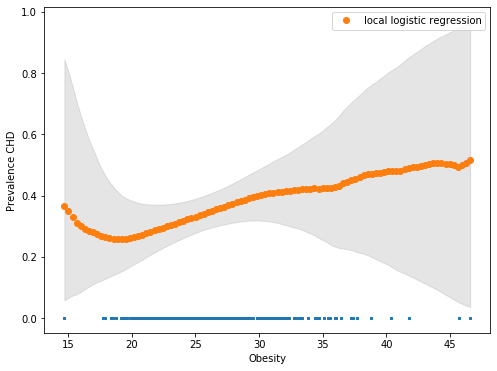

In [140]:
print('min ',np.min(X[:,1]),' ','max ',np.max(X[:,1]))
plt.subplots(figsize=(8,6))
plt.ylabel("Prevalence CHD")
plt.xlabel("Obesity")
plt.plot(X[:,1],np.zeros((X[:,1].shape[0],),dtype=float),'s',markersize=2)
plt.fill_between(lines,yy1+std1[:,0],yy1+std1[:,1],color='gray',alpha=0.2)
plt.plot(lines,yy1,'o',label='local logistic regression')
plt.legend()

In [159]:
lrr2 =LocalLogisticRegression()
lbd=5

lines =np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
[desnity0,kernel0]=lrr2.kerneldensity(X=X[:,0][y==0],lines=lines,lbd=lbd)
[density1,kernel1]=lrr2.kerneldensity(X=X[:,0][y==1],lines=lines,lbd=lbd)
posteriors =lrr2.posterior(X=X[:,0],y=y,lines=lines,lbd=lbd)

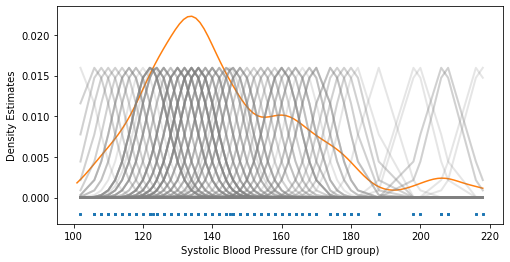

In [164]:
plt.subplots(figsize=(8,4))
plt.xlabel('Systolic Blood Pressure (for CHD group)')
plt.ylabel('Density Estimates')
plt.plot(X[:,0][y==1],np.zeros((y[y==1].shape[0],),dtype=float)-0.002,'s',markersize=2)
plt.plot(lines,density1,'-')
sorts =np.argsort(X[:,0][y==1])
for i in range(y[y==1].shape[0]):
    plt.plot(X[:,0][y==1][sorts],0.2*kernel1[i,:][sorts],'-',color='gray',linewidth=2,alpha=0.2)

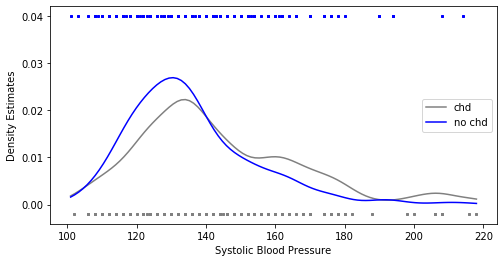

In [167]:
plt.subplots(figsize=(8,4))
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Density Estimates')
plt.plot(X[:,0][y==1],np.zeros((y[y==1].shape[0],),dtype=float)-0.002,'s',markersize=2,color='gray')
plt.plot(X[:,0][y==0],np.zeros((y[y==0].shape[0],),dtype=float)+0.04,'s',markersize=2,color='blue')
plt.plot(lines,density1,'-',color='gray',label="chd")
plt.plot(lines,desnity0,'-',color='blue',label="no chd")
plt.legend()

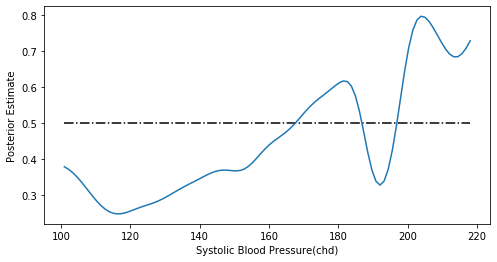

In [172]:
plt.subplots(figsize=(8,4))
plt.xlabel('Systolic Blood Pressure(chd)')
plt.ylabel('Posterior Estimate')
plt.plot(lines,0.5*np.ones((lines.shape[0],),dtype=float),'-.k')
plt.plot(lines,posteriors[:,1],'-')

In [190]:
X =np.array(data[:,8],dtype=float)
y =np.array(data[:,9],dtype=float)
lines =np.linspace(np.min(X),np.max(X),200)

In [215]:
class GMM:
    def __init__(self,K=2):
        self.K =K
    
    def fit(self,X,lines,y):
        K =np.unique(y).shape[0]
        print('K ',K)
        self.K =K
        N=X.shape[0]
        
        m =lines.shape[0]
        
        mu =np.zeros((K,1),dtype=float)
        var =np.zeros((K,1),dtype=float)
        pb =np.zeros((K,1),dtype=float)
        
        gamma =stats.norm.rvs(loc=3,scale=1,size=(N,K))
        gamma =gamma/np.sum(gamma,axis=1)[:,np.newaxis]
        
        mu =gamma.T.dot(X[:,np.newaxis])[:,0]/np.sum(gamma,axis=0)
        var =np.sum(np.multiply(gamma,np.square(X[:,np.newaxis]-mu.T)),axis=0)/np.sum(gamma,axis=0)
        pb =np.sum(gamma,axis=0)
        
        maxiters =1000
        w =0
        gamma_last =np.zeros_like(gamma,dtype=float)
        tol =1e-7
        while(w<maxiters and np.linalg.norm(gamma_last-gamma)>tol):
            gamma_last =gamma
            w =w +1
            for k in range(K):
                gamma[:,k]=stats.norm.pdf(X,loc=mu[k],scale=np.sqrt(var[k]))*pb[k]
            gamma =gamma/np.sum(gamma,axis=1)[:,np.newaxis]
            
            mu =gamma.T.dot(X[:,np.newaxis])[:,0]/np.sum(gamma,axis=0)
            var =np.sum(np.multiply(gamma,np.square(X[:,np.newaxis]-mu.T)),axis=0)/np.sum(gamma,axis=0)
            pb =np.mean(gamma,axis=0)
        
        res =np.zeros((m,K),dtype=float)
        posteriors =np.zeros((m,),dtype=float)
        for i in range(m):
            
            for k in range(K):
                res[i,k]=stats.norm.pdf(lines[i],loc=mu[k],scale=np.sqrt(var[k]))
            
        posteriors =np.multiply(res,pb[np.newaxis,:])
        posteriors =np.sum(posteriors,axis=1)
        
        return [posteriors,res,mu,var,pb]
        
            
        
        
        
            
        
        
        
        
        
        

In [216]:
gmm =GMM()
[post,res,mu,var,pb]=gmm.fit(X=X,lines=lines,y=y)

K  2


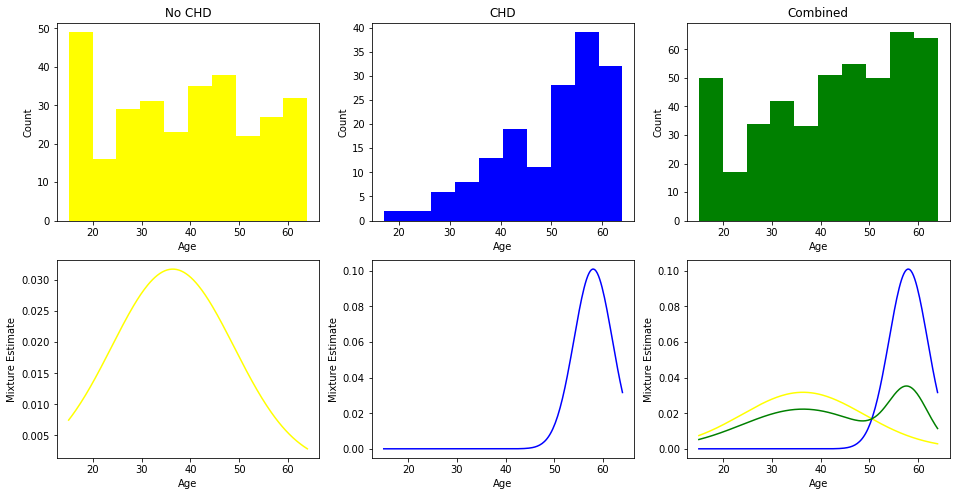

In [228]:
plt.subplots(figsize=(16,8))
plt.subplot(2,3,1)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("No CHD")
plt.hist(X[y==0],color="yellow")
plt.subplot(2,3,2)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("CHD")
plt.hist(X[y==1],color="blue")
plt.subplot(2,3,3)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Combined")
plt.hist(X,color="green")
plt.subplot(2,3,4)
plt.xlabel("Age")
plt.ylabel("Mixture Estimate")
plt.plot(lines,res[:,1],'-',color="yellow")
plt.subplot(2,3,5)
plt.xlabel("Age")
plt.ylabel("Mixture Estimate")
plt.plot(lines,res[:,0],'-',color="blue")
plt.subplot(2,3,6)
plt.xlabel("Age")
plt.ylabel("Mixture Estimate")
plt.plot(lines,res[:,1],'-',color="yellow")
plt.plot(lines,res[:,0],'-',color="blue")
plt.plot(lines,post,'-',color="green")


In [237]:
print('mu ',mu)
print('var ',var)
print('pb ',pb)
outputs =np.zeros((X.shape[0],2),dtype=float)
for k in range(2):
    outputs[:,k]=stats.norm.pdf(X,loc=mu[k],scale=np.sqrt(var[k]))*pb[k]
outputs =np.argmax(outputs,axis=1)



mu  [57.98455119 36.38116401]
var  [ 15.58811616 157.67473737]
pb  [0.29786317 0.70213683]


In [238]:
kinds =np.zeros((2,2),dtype=float)
for i in range(outputs.shape[0]):
    if(outputs[i]==y[i] and y[i]==1.0):
        kinds[1][1]=kinds[1][1]+1
    elif(outputs[i]==y[i] and outputs[i]==0.0):
        kinds[0][0]=kinds[0][0]+1
    elif(outputs[i]==1.0 and y[i]==0.0):
        kinds[0][1]=kinds[0][1]+1
    else:
        kinds[1][0]=kinds[1][0]+1

In [239]:
outputs

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,

In [187]:
np.sum(tt3,axis=0).shape

(3,)